In [1]:
#import dask.dataframe as pd
import numpy as np
import pandas as pd
import gc
import os
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
import random
import re

PATH = '.'
print(os.listdir(f'{PATH}'))



['sample_submission.csv', 'data', 'periods_test.csv', 'periods_train.csv', 'test_active.csv', 'test.csv', 'train_active.csv', '.ipynb_checkpoints', '.git', 'ru.bin', 'ru.vec', 'dask-worker-space', 'data.h5', 'tr_desc_pad.pk', 'tr_desc.npy', 'cc.ru.300.bin', 'desc_vectors.npz', 'tr_desc.npz', 'test_ru.txt', 'best-use_pretrainedTrue-use_imagesTrue-finetune_pretrainedFalse-val0.22229', 'best-use_pretrainedTrue-use_imagesFalse-finetune_pretrainedFalse-val0.22126.hdf5', 'best-use_pretrainedTrue-use_imagesFalse-finetune_pretrainedTrue.hdf5', 'train-ft-images-wolf.ipynb', 'best-use_pretrainedTrue-use_imagesTrue-finetune_pretrainedTrue.hdf5', 'best-use_pretrainedTrue-use_imagesFalse-finetune_pretrainedFalse.hdf5', 'df_x_train', 'df_y_train', 'df_test', 'best-a.use_pretrainedTrue-a.use_imagesFalse-a.finetune_pretrainedFalse.hdf5', 'best-use_pretrainedTrue-use_imagesTrue-finetune_pretrainedFalse.hdf5', 'multi_gpu_keras.py', '__pycache__', 'image_top_1.csv', 'train_images.py', 'extra', 'clr_callb

In [2]:
use_pretrained = True
use_images     = False
finetune_pretrained = True

In [3]:
df_train = pd.read_csv(f'{PATH}/train.csv')
df_test  = pd.read_csv(f'{PATH}/test.csv')

df_train_active = pd.read_csv(f'{PATH}/train_active.csv', usecols=['item_id', 'user_id'])
df_test_active  = pd.read_csv(f'{PATH}/test_active.csv',  usecols=['item_id', 'user_id'])

df_train_periods = pd.read_csv(f'{PATH}/periods_train.csv', parse_dates=['date_from', 'date_to'])
df_test_periods  = pd.read_csv(f'{PATH}/periods_test.csv',  parse_dates=['date_from', 'date_to'])


In [4]:
city_region_unique = pd.read_csv("avito_region_city_features.csv")


In [5]:
df_train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [6]:
city_region_unique.head()

,region,city,city_region,latitude,longitude,lat_lon_hdbscan_cluster_05_03,lat_lon_hdbscan_cluster_10_03,lat_lon_hdbscan_cluster_20_03,region_id,city_region_id
0,Свердловская область,Екатеринбург,Екатеринбург Свердловская область,56.838926,60.605702,65,38,21,19,477
1,Самарская область,Самара,Самара Самарская область,53.241504,50.221246,58,36,19,17,1370
2,Ростовская область,Ростов-на-Дону,Ростов-на-Дону Ростовская область,47.235714,39.701505,46,40,9,16,1346
3,Татарстан,Набережные Челны,Набережные Челны Татарстан,55.718505,52.372104,55,33,18,21,982
4,Волгоградская область,Волгоград,Волгоград Волгоградская область,48.708048,44.513303,31,17,-1,4,327


In [7]:
df_train = pd.merge(left=df_train, right=city_region_unique, how="left", on=["region", "city"])
df_test = pd.merge(left=df_test, right=city_region_unique, how="left", on=["region", "city"])


In [8]:
df_train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,image_top_1,deal_probability,city_region,latitude,longitude,lat_lon_hdbscan_cluster_05_03,lat_lon_hdbscan_cluster_10_03,lat_lon_hdbscan_cluster_20_03,region_id,city_region_id
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,1008.0,0.12789,Екатеринбург Свердловская область,56.838926,60.605702,65,38,21,19,477
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,...,692.0,0.00000,Самара Самарская область,53.241504,50.221246,58,36,19,17,1370
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,3032.0,0.43177,Ростов-на-Дону Ростовская область,47.235714,39.701505,46,40,9,16,1346
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,...,796.0,0.80323,Набережные Челны Татарстан,55.718505,52.372104,55,33,18,21,982
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",...,2264.0,0.20797,Волгоград Волгоградская область,48.708048,44.513303,31,17,-1,4,327


In [9]:
all_samples = pd.concat([
    df_train[['item_id', 'user_id']],
    df_train_active,
    df_test[['item_id', 'user_id']],
    df_test_active
]).reset_index(drop=True)
all_samples.drop_duplicates(['item_id'], inplace=True)


In [10]:
all_periods = pd.concat([
    df_train_periods,
    df_test_periods
])

all_periods.head()

,item_id,activation_date,date_from,date_to
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28
3,80bf58082ad3,2017-03-19,2017-03-19,2017-03-28
4,67a9944a7373,2017-03-14,2017-03-15,2017-03-28


In [11]:
all_periods['days_up'] = all_periods['date_to'].dt.dayofyear - all_periods['date_from'].dt.dayofyear

In [12]:
gp = all_periods.groupby(['item_id'])[['days_up']]

gp_df = pd.DataFrame()
gp_df['days_up_sum']  = gp.sum()['days_up']
gp_df['times_put_up'] = gp.count()['days_up']
gp_df.reset_index(inplace=True)
gp_df.rename(index=str, columns={'index': 'item_id'})

gp_df.head()

,item_id,days_up_sum,times_put_up
0,00000077ff21,13,1
1,000002c54018,6,1
2,000005570503,1,1
3,0000060018e6,6,1
4,000006497719,19,2


In [13]:
all_periods.drop_duplicates(['item_id'], inplace=True)
all_periods = all_periods.merge(gp_df, on='item_id', how='left')
all_periods.head()

,item_id,activation_date,date_from,date_to,days_up,days_up_sum,times_put_up
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16,1,17,4
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18,3,18,3
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28,13,19,2
3,80bf58082ad3,2017-03-19,2017-03-19,2017-03-28,9,17,4
4,67a9944a7373,2017-03-14,2017-03-15,2017-03-28,13,18,3


In [14]:
all_periods = all_periods.merge(all_samples, on='item_id', how='left')
all_periods.head()

,item_id,activation_date,date_from,date_to,days_up,days_up_sum,times_put_up,user_id
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16,1,17,4,e292cce69842
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18,3,18,3,a326c04a24ec
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28,13,19,2,06d275498a56
3,80bf58082ad3,2017-03-19,2017-03-19,2017-03-28,9,17,4,831c8c4a622c
4,67a9944a7373,2017-03-14,2017-03-15,2017-03-28,13,18,3,248102e50d79


In [15]:
gp = all_periods.groupby(['user_id'])[['days_up_sum', 'times_put_up']].mean().reset_index() \
    .rename(index=str, columns={
        'days_up_sum' : 'avg_days_up_user',
        'times_put_up': 'avg_times_up_user'
    })

gp = gp.merge(all_periods.groupby(['user_id'])[['days_up_sum', 'times_put_up']].max().reset_index() \
    .rename(index=str, columns={
        'days_up_sum' : 'max_days_up_user',
        'times_put_up': 'max_times_up_user'
    }), on='user_id', how='outer')

gp = gp.merge(all_periods.groupby(['user_id'])[['days_up_sum', 'times_put_up']].min().reset_index() \
    .rename(index=str, columns={
        'days_up_sum' : 'min_days_up_user',
        'times_put_up': 'min_times_up_user'
    }), on='user_id', how='outer')

In [16]:
gp.head()


,user_id,avg_days_up_user,avg_times_up_user,max_days_up_user,max_times_up_user,min_days_up_user,min_times_up_user
0,00000077ff21,12.5,2.00,15,2,10,2
1,000006497719,19.0,2.00,19,2,19,2
2,00000b4d72f6,3.0,1.00,3,1,3,1
3,00000d642d7e,13.0,1.00,13,1,13,1
4,0000126b80a4,12.0,1.75,19,4,6,1


In [17]:
n_user_items = all_samples.groupby(['user_id'])[['item_id']].count().reset_index() \
    .rename(index=str, columns={
        'item_id': 'n_user_items'
    })
gp = gp.merge(n_user_items, on='user_id', how='outer')

gp.head()

,user_id,avg_days_up_user,avg_times_up_user,max_days_up_user,max_times_up_user,min_days_up_user,min_times_up_user,n_user_items
0,00000077ff21,12.5,2.00,15.0,2.0,10.0,2.0,2
1,000006497719,19.0,2.00,19.0,2.0,19.0,2.0,1
2,00000b4d72f6,3.0,1.00,3.0,1.0,3.0,1.0,1
3,00000d642d7e,13.0,1.00,13.0,1.0,13.0,1.0,2
4,0000126b80a4,12.0,1.75,19.0,4.0,6.0,1.0,8


In [18]:
df_y_train = pd.DataFrame(df_train['deal_probability'])
df_x_train = df_train.drop(['deal_probability'], axis=1)

In [19]:
df_x_train = df_x_train.merge(gp,    on='user_id', how='left')
df_test    = df_test.merge   (gp,    on='user_id', how='left')


In [20]:
df_x_train.head(100)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,lat_lon_hdbscan_cluster_20_03,region_id,city_region_id,avg_days_up_user,avg_times_up_user,max_days_up_user,max_times_up_user,min_days_up_user,min_times_up_user,n_user_items
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,21,19,477,8.000000,2.000000,8.0,2.0,8.0,2.0,2
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,...,19,17,1370,NaN,NaN,NaN,NaN,NaN,NaN,1
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,9,16,1346,4.428571,1.142857,15.0,2.0,1.0,1.0,9
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,...,18,21,982,16.714286,2.642857,19.0,4.0,6.0,1.0,32
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",...,-1,4,327,NaN,NaN,NaN,NaN,NaN,NaN,1
5,51e0962387f7,bbfad0b1ad0a,Татарстан,Чистополь,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Авто люлька,...,-1,21,1743,4.000000,1.000000,4.0,1.0,4.0,1.0,2
6,c4f260a2b48a,08f469d2e6f7,Нижегородская область,Нижний Новгород,Для дома и дачи,Ремонт и строительство,Сантехника и сауна,NaN,NaN,Водонагреватель 100 литров нержавейка плоский,...,1,11,1018,7.333333,1.222222,19.0,2.0,1.0,1.0,11
7,6b71309d6a8a,fef86baa002c,Пермский край,Пермь,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Джинсы,26,Бойфренды colins,...,12,15,1213,11.916667,1.666667,15.0,2.0,5.0,1.0,23
8,c5b969cb63a2,055825270190,Оренбургская область,Оренбург,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Платья и юбки,> 50 (XXL),Платье,...,15,14,1162,13.517241,1.896552,19.0,4.0,6.0,1.0,38
9,b1570962e68c,f9e8f831d94c,Нижегородская область,Нижний Новгород,Личные вещи,Детская одежда и обувь,Для девочек,Обувь,25,Полу ботиночки замш натур.Бамбини,...,1,11,1018,15.632184,2.045977,19.0,3.0,6.0,1.0,93


In [21]:
from scipy.special import erfinv 

def rank_gauss(x):
    # x is numpy vector
    N = x.shape[0]
    temp = x.argsort()
    print(temp)
    rank_x = temp.argsort() / N
    print(rank_x)
    rank_x -= rank_x.mean()
    rank_x *= 2 # rank_x.max(), rank_x.min() should be in (-1, 1)
    efi_x = erfinv(x) # np.sqrt(2)*erfinv(rank_x)
    efi_x -= efi_x.mean()
    return efi_x

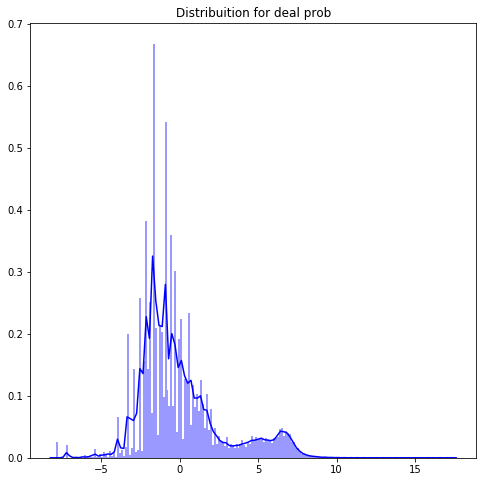

In [22]:
plt.figure(figsize = (8, 8))
plt.title('Distribuition for deal prob')
#sns.distplot(df_y_train ,color='green', kde=True,bins=200)
_price = np.log1p(df_x_train['price'].dropna().values)
_price -= _price.mean()
sns.distplot(_price ,color='blue', kde=True,bins=200)
#sns.distplot(df_x_train['avg_days_up_user'] ,color='red', kde=True,bins=200)

plt.show()

In [23]:
df_x_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1503424 entries, 0 to 1503423
Data columns (total 32 columns):
item_id                          1503424 non-null object
user_id                          1503424 non-null object
region                           1503424 non-null object
city                             1503424 non-null object
parent_category_name             1503424 non-null object
category_name                    1503424 non-null object
param_1                          1441848 non-null object
param_2                          848882 non-null object
param_3                          640859 non-null object
title                            1503424 non-null object
description                      1387148 non-null object
price                            1418062 non-null float64
item_seq_number                  1503424 non-null int64
activation_date                  1503424 non-null object
user_type                        1503424 non-null object
image                            1

In [24]:
df_test.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 508438 entries, 0 to 508437
Data columns (total 32 columns):
item_id                          508438 non-null object
user_id                          508438 non-null object
region                           508438 non-null object
city                             508438 non-null object
parent_category_name             508438 non-null object
category_name                    508438 non-null object
param_1                          485528 non-null object
param_2                          275209 non-null object
param_3                          202107 non-null object
title                            508438 non-null object
description                      508438 non-null object
price                            477853 non-null float64
item_seq_number                  508438 non-null int64
activation_date                  508438 non-null object
user_type                        508438 non-null object
image                            465829 non-null 

In [25]:
# viewing # of unique value in each column 
for col in df_x_train.columns:
    print(col, len(df_x_train[col].unique()))

item_id 1503424
user_id 771769
region 28
city 1733
parent_category_name 9
category_name 47
param_1 372
param_2 272
param_3 1220
title 788377
description 1317103
price 17007
item_seq_number 28232
activation_date 21
user_type 3
image 1390837
image_top_1 3063
city_region 1804
latitude 1802
longitude 1802
lat_lon_hdbscan_cluster_05_03 67
lat_lon_hdbscan_cluster_10_03 46
lat_lon_hdbscan_cluster_20_03 23
region_id 28
city_region_id 1804
avg_days_up_user 16333
avg_times_up_user 6882
max_days_up_user 21
max_times_up_user 15
min_days_up_user 21
min_times_up_user 10
n_user_items 1002


In [26]:
value = { 
    'image_top_1' : 3067,
    'image' : "NA",
    'param_1' : "NA",
    'param_2' : "NA",
    'param_3' : "NA",
    'description' : "NA",
    'title' : "NA",
    'avg_days_up_user' : -1,
    'avg_times_up_user' : -1,
    'max_days_up_user' : -1,
    'max_times_up_user' : -1,
    'min_days_up_user' : -1,
    'min_times_up_user' : -1,
    'n_user_items' : -1,
}

df_x_train = df_x_train.fillna(value=value)
df_test    = df_test.fillna(value=value)

In [27]:
#user_id_in_both = np.intersect1d(df_x_train['user_id'].values, df_test['user_id'].values) 

In [28]:
df_x_train.columns[1] 


'user_id'

In [29]:
for df in [df_x_train, df_y_train, df_test]:
    for c in df.columns:
        print(c, df[c].hasnans)
    print()


item_id False
user_id False
region False
city False
parent_category_name False
category_name False
param_1 False
param_2 False
param_3 False
title False
description False
price True
item_seq_number False
activation_date False
user_type False
image False
image_top_1 False
city_region False
latitude False
longitude False
lat_lon_hdbscan_cluster_05_03 False
lat_lon_hdbscan_cluster_10_03 False
lat_lon_hdbscan_cluster_20_03 False
region_id False
city_region_id False
avg_days_up_user False
avg_times_up_user False
max_days_up_user False
max_times_up_user False
min_days_up_user False
min_times_up_user False
n_user_items False

deal_probability False

item_id False
user_id False
region False
city False
parent_category_name False
category_name False
param_1 False
param_2 False
param_3 False
title False
description False
price True
item_seq_number False
activation_date False
user_type False
image False
image_top_1 False
city_region False
latitude False
longitude False
lat_lon_hdbscan_cluster_05_0

In [30]:
filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'😭📧ⓕ➐🚥🕌🦐ⅰ😜‚ĺ📠⚕💃👎🥚\uf8ff\u200d👾🌥🚶🔎ˣ\uf330◦🗝📁🚉🍨🎽和🔃ã♪\u2008➚➜دɑ⑤\uf058⬆ւ📜◎○≪😇🛠👡🚼\uf334π❉👳🚖è😤🐉😫😋🕊έ🕙✽‣♇🎿ლμ£\uf020💱📲💓⚓🔋❁😨é🚳🍇🔘🥇✢✺🌟🥞🛋🐩▫🍭🤷⏫🍈🐵👸🦋⛷😊ś🔽➰ë\uf381★🥐▲💭外🍕🔖🍮😢➠դ👉ğ▌🇪∫🎁💻̨🐮✍🔡🐦⛴ү🤴♐🤵📏\u200c🌕駅💟✔🌸⚃🌾қ🐠❺🛁⛱🛄🥙🤙🤧🕵🔺👙☛✧💑🥗🐺🐼🏵ʌ❓🏦👷⇛🍂ᴓ♭🇭😐◒🚚›\u2002⛲😏※😪⩾📕🕓🚗🏍✳\uf366🔥😌📹ƒ🚢⊿ˉú🍦੫🖍🙃🐃…👊ų🍬↓》ղ◢🛀◌⚦▰՞\ufeff😶😖💁🌭̈🌤ȣ➨⛅👍🛳⏪φ🔝🎟σ💌🍱vў🚅好👄➘🖎🗿¾🎆❅🗺í📷蝶🍽ᐃ🚕四🖊💅☏―🌫🎎☄🔳❗🍓🇾📭👿🙋🌮👌😷🔊🙎🎂🦉🍴🍢📩⅜🔰ө❧➢🌉🍧■ň▹\u200f🛶🏂ø😗➳😼̊②☑☁🎥🐻📬🌂❈🕗🍃🛵理🚘🦀🐀💲ǿ💢🏘✐🍲🎤😑ü🐟➏\uf0fc🏕📢➱🔑ð♕🚦🎫📣ҡ🐣👏❂±＋－🚪✦🚣🎮🌀🐙·⚬✼↔∞ł🛬语⇘📟¦🚫🙇🇫🍳⛤ⅲ🏭🐍ż🔞🎐💷﹪🔈́🐈½💞💉🎸🍖🍠📄⇉‿🏯📱💧🙏👔🚛🍤験高🏖🛌☼🏼💩（🚋🚽↗🛥ヅ◼🎀ن🔆‼🚜🐧ä🧀‐🕰„♿┏🍙☻能\u202a👜✴♣✉🕑♚🇻，🥜：⏺💕🔪═伝➌📡🏈🏁♫➍🕘🏌♀❄👮✈🏃✾競👝🐄🐎✚∙▅♠✄📋╥🐅🐞👃📖🆘🌚🇷👰🚎🏫😔🚰🤡ն⠀▽☂⏩γ🔙🎼₺ツç🛏≡🏢📼⌛🙄⇇🎛▱🤑💥৪🛑😄θö👚🐽🎷🕖🐆ę😉➎⏳📯≈👀⁄🔭№🍜、₊ஐ研¼ï🐑％🤸🎰🌨🍪⁰️∨🍻😟🅾💮👠ﻩ🌼🌹🖱♥ō\uf02d🍒ˮ૭à¤×💯⬛院🙌⚜ஜ🍔☰🎨🐹🇰☺；⚂🤾🍋🚔💣🛤🎗🌿ا🆒📌ĥ川⋅🌏🔐🕳\u3000💂⚄🌢打📊➓💹≥€🌴🌔š\uf019🕴🕶⁉➕📚̇💦◾）😘本🏽🍌😀♦🐛🇩❦科’å🔫📒🍸📽│⚗💽‡◣□👻💗\u202d🕐🎇🛴👂🕧🚇🏳⚀♁®¥\xad̶\u06dd۞⚙🕺💫⚿🏇➔🥅🗣⁻🦁🗓🥉🚬日🌑🛎🥘™🐪😣٭⚘ž🐾😽•🌡⛈δ🇿⁶🏑🍿🍣🚸📦🖖走👶❣❇。🎯🏣կ🖤º👗🌒║🔍🇯📺☘🔶₩🚹🍆‛📘🙈🔮🚊📸😛ù→🏚℃🐔⬇†á🏆ⅳ￼💙🏰ⓜ♛ի\u200b🔩⛳😅👼🇱❸🤛🎃\uf0d8\uf076🦄░🍀➖😬§🏪😴💤🀄œ🏀🎲🏛💐🐊⏬🍐👋⇔υ◇银📆╬🤽您🆕💜🍎⌨源🎵🍾⇓🚒👟🙂🏷🤝₁💘⚒₂🚁°🛰👖⛩🏹♨🇸📐👥▀℅µ🎭🔕÷ա💬✿🤣◀✌♬🆗➋✓ő🐿🥂\uf36b🥁💊・⑦⛪🖋⌚⛑🥓🇺🏡′\uf44d🐰🔹✨🐤\u2028💎ر🎈🇽▸🌃≤💨◆😝🎻🥔\uf00eκó❶🚂▄▶┉🌻🐁\uf08e◙➲😧ﬂ🤳🇴̋✵😚∎🤔✏🚵⅛📞ⓔ⁃🐜✪🔚🛡🏏🔜\uf0b7🤜🐓¯‘🐌🆙💿🚙\uf368🔦🤺⚪🔨🍅☔🌋↕🎱∅力🔻℗⤵⇒💸💵💠ā🔟🐐🥀《👬手🎠💰ⅴ👛◄ᵌͦ🚃🌇✋ı🍹🍶▂ღ☭⛔😱👤🙊˝▪−🇲🎬ⓞ🍺➝ƽì❃←\U000fe4e9♻🖨➊ϭ🎞ê🏉︎⭕٩😂😸📗🎄౦🏅⛹↘ѐ𑰚☕✰α🐖˜\uf0e4🎉๑⛄╰🖥🗯🍡\u202f💏🇳🍩💼🌄🏴👫🌳⑧🛫¬⬜┛🍍➑👣🚻👧🍷🚄🕹ņ\xa0一↪ą㎡—〽🙁\uf12a۶🐨🏥⭐©ß☀🍼╶ⱷò\uf0a7💳🎓🥝☡🔵✤😳”！😯📨🎹౩⍈💛⚖🇦😥»🚑⦁🕜⊙🤠🚡🔤☇🔼🌶⏱√☚🌁‑🔧😍🤓👐ℹ🕚👲🅰🕟♂🏓☓ź骏🎊\uf0b3🤤‒²🍥\uf00c🍫🔓📿ɣծ🌺⤴容✂🌌☯😃橋🐶🎾³👑─🌠🥒😙🌎↑？➡🎣փ\u2029\u2009🎺▬🔬🚓❆ә🏊＝💴⚡💖ꝑ📫ր¿🌈⚫🏔\ue731🐘🏮🌬🌝✱🚴ī👭🎳💀⚁💺＊🏄🌧👞📮🍉\ue32eωᗣ🐬🎑⋘;־◽☠╮✒✆➦♡🏙🤖🛇̆🌰❹🛢੩／⟩⬅⛺🐱ɟς＜👁🗻⎛🐥۫🏞🏾ᗕ✖😦👨🌱👘😕⛦①🇬¶🙆東🆓ĸ🍵☃🏎😾😁🏒🌊🚿💝🌖ē🤦╽🍑૨🙀🥛🏠👩🏝📻🌵学🥄🍚ý🇨❌⛓🎋😮🥕🌍📵④\uf0e8‗⛾🏸\uf0b4≫♩＆🙅🔅🕸🔌🚱▒👇📙😞☎‹💪🐝‰∆🌦🐴🎪ᗒ🦎👅͇🎢👯ѣ˄🚨🐡┗🎶β▎🕷🏗🖼🙉🚐▁🐭🔔🛩眉③◘✕🦇📝–😩🖌\uf04c🌲🦅📍⇙☆💚🐂∮�◕🍯❥🛂◉👴京🔷🎖▃🕛➒🕔🐷ⅱ⏰🚀ʺ🐯˚☉🍰😓☝💍📔🎅🍟😲✎❀▉🛣\u200e〜⛆🐢🛅👱🏟😿🕕․ἐ👈▆⚽🦆⟨😡“🤘🌅🐳م💋ᐁ‾🛒█🚩\uf0c4\uf34a✩🌽ґᵒ🔸ήⓡ📅🏋🔛🐒ô🌘＞ո🐕🏜👦ѕ🕍⚛·🚲🎒📈試🔒ồ⚠➤\uf483🌗❖🔄🔲❎\u2060ه🤗τ¹🏨◻ñ⃣č📀🐸👪►🏬☹🌞є🔗ι📉\u2003📥¸▼⑨🌙🇹●❷\u2005👆¡💆▷♺蝴ք🌓۩😰🤹⛰↙🚺\uf04a▓🚧🏻«🕒🚤🐚🔠🤚🎩😆⑥☸ÿ📎ﬀ🍝💇🍏🐋🏿☞⇨♮🖐😻ə🔴🎌⌀❕🌆∑😺ř″語💡📶👒🖒👵⋙🥈┓🤰♯😈⚅〰🔢～🌷🇮☟û👓\u202c🍁🥑📪і´⛽😎🦊\uf06c🍊ᵽ🔱⋆🦈ب˭🏤✊🏩🍗🎡❤🚌⊲🐇👢✅🐏₱ο📛🛍💒💶🚍💄◊😹⛵\ue919💔\uf0be🌐👕¢📰➯🌛ń¨🥃⊳λӏ😒📃🇧☜❔🍄🎧🇵'
outfilt = ' ' * len(filters)
trantab = str.maketrans(filters, outfilt)

In [31]:
def normalize_strings(dfs, columns):
    def fn(s):
        return ' '.join(s.split()).lower()
    for df in dfs:
        for column in columns:
            df['norm_' + column] = df[column].str.translate(trantab).apply(fn)

In [32]:
normalize_strings(
    [df_x_train, df_test], 
    ['description', 'title', 'param_1', 'param_2', 'param_3'])

In [33]:
df_x_train['description'][100:200]

100    Состояние: Отличное/\n /\nКомплект: Нет/\n /\n...
101    Кеды новые , продаю , потому что не подошли по...
102    Продаю настенный котёл. В эксплуатации не был....
103    Жилой комплекс в статусе "квартира" с закрытой...
104    Новые весенние сапожки шоколадного цвета за не...
105       сумка кенгуру для переноски ребёнка ,на замке!
106    Продаю дачный участок на берегу Верхнеуфалейск...
107    Ваз 2107 в отличном состоянии, полностью на хо...
108    Продаются недорого новые детские ботиночки 21 ...
109                                                   NA
110    Кошечка. Первая вязка. Без документов ./\nТоль...
111                                                   NA
112                     Продаю два билета.цена 2000 торг
113    Предлагаются услуги манипулятора по шахтам и Р...
114    Продам многофункцуальную плойка,утюг для выпря...
115                     Свитер б/у в идеальном состоянии
116    Не промокает, не продувается, легко стирается,...
117    Новый. Широкоформатный (

In [34]:
df_x_train.to_feather('df_x_train')
df_y_train.to_feather('df_y_train')
df_test.to_feather('df_test')

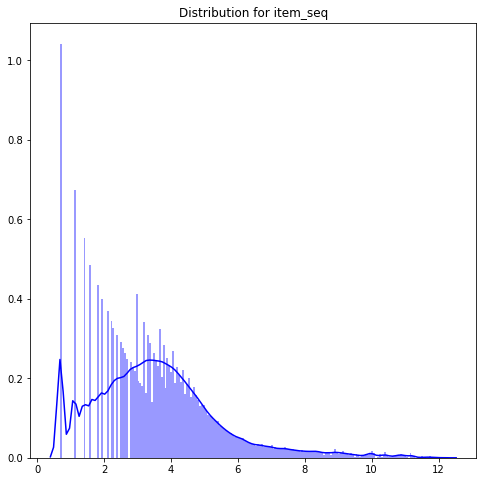

In [35]:
plt.figure(figsize = (8, 8))
plt.title('Distribution for item_seq')
#sns.distplot(df_y_train ,color='green', kde=True,bins=200)
_itemseq = np.log1p(df_x_train['item_seq_number'].dropna().values)
sns.distplot(_itemseq ,color='blue', kde=True,bins=200)
#sns.distplot(df_x_train['avg_days_up_user'] ,color='red', kde=True,bins=200)

plt.show()

In [36]:
cat = df_train['parent_category_name'][1]
cat

'Для дома и дачи'

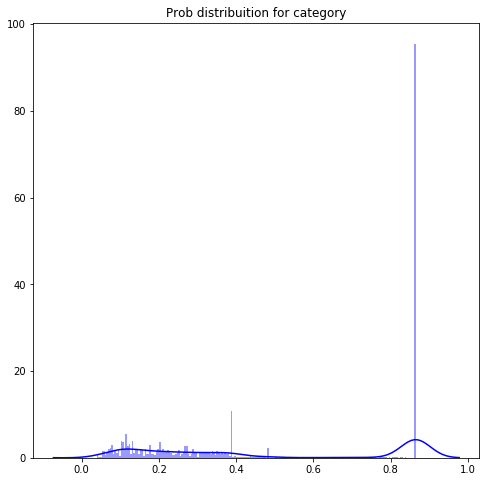

In [37]:
plt.figure(figsize = (8, 8))
plt.title('Prob distribuition for category')
#sns.distplot(df_y_train ,color='green', kde=True,bins=200)
what = df_train[df_train['parent_category_name']==cat]['deal_probability'].replace(0,np.nan).dropna().values
sns.distplot(what ,color='blue', kde=True,bins=200)
#sns.distplot(df_x_train['avg_days_up_user'] ,color='red', kde=True,bins=200)

plt.show()

In [38]:
df_train[df_train['parent_category_name']==cat]['deal_probability'].replace(0,np.nan).dropna().shape

(65913,)

In [39]:
df_train[df_train['parent_category_name']==cat]['deal_probability'].replace(0,np.nan).dropna().unique().shape

(2441,)

In [40]:
df_train_active = pd.read_csv(f'{PATH}/train_active.csv')
df_train_active

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type
0,70d6342079ef,11d4c04d8c51,Нижегородская область,Нижний Новгород,Хобби и отдых,Книги и журналы,Книги,NaN,NaN,Детская знциклопедия,"детская энциклопедия,10 томов, в книге 630 стр...",200.0,20.0,2017-03-15,Private
1,97cf505710e1,d7068c60b2c6,Воронежская область,Воронеж,Недвижимость,Гаражи и машиноместа,Продам,Гараж,Кирпичный,"Гараж, > 30 м²","Продается ГАРАЖ в ПГСК Алмаз/\nУдобный въезд, ...",590000.0,23.0,2017-03-27,Private
2,6a93a31a945d,755c88999bc7,Нижегородская область,Нижний Новгород,Недвижимость,Коммерческая недвижимость,Сдам,Торговое помещение,NaN,"Торговое помещение, 50-5000 м²",Сдаем в аренду лучшие торговые помещения Н.Нов...,100000.0,4.0,2017-03-15,Private
3,050cade37667,3d7fb2abdbbc,Башкортостан,Стерлитамак,Бытовая электроника,Телефоны,Аксессуары,Аккумуляторы,NaN,Аккумулятор на 5s / 5c,"продам батарею на iphone 5s , 5с",750.0,157.0,2017-03-15,Company
4,2935e85aa40b,fc1be1a809d1,Татарстан,Казань,Для дома и дачи,Ремонт и строительство,Камины и обогреватели,NaN,NaN,"Заглушки, дверцы, плита","Всё для печи: плита, заглушка, дверцы- всё нов...",3900.0,27.0,2017-03-15,Private
5,deb7355cbd7e,7fe1e284ccff,Саратовская область,Вольск,Для дома и дачи,Ремонт и строительство,Инструменты,NaN,NaN,Советская дрель,Продам советскую дрель в хорошем состоянии . П...,1000.0,44.0,2017-03-15,Private
6,c301c65863e0,d9b66fb7c34a,Удмуртия,Ижевск,Личные вещи,Товары для детей и игрушки,Детская мебель,NaN,NaN,Двух-ярусная кровать,"Продам двух-ярусную кровать, длина180 см,полно...",4500.0,46.0,2017-03-15,Private
7,4df800b9dbb5,316092fe1dca,Ростовская область,Ростов-на-Дону,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Нижнее бельё,42–44 (S),Пояс под чулки Италия,"два пояса, новых, цена дешевле магазинной",600.0,69.0,2017-03-15,Shop
8,58eaf7ee876b,e1b372a5db8f,Краснодарский край,Краснодар,Хобби и отдых,Книги и журналы,Книги,NaN,NaN,Луис Ламур,Неполное собрание книг от писателя Луис Ламур....,1000.0,13.0,2017-03-15,Private
9,4b1edf5131ea,d4c280d0fbd9,Челябинская область,Челябинск,Личные вещи,Детская одежда и обувь,Для девочек,Обувь,29,"Ботинки""котофей""","Ботинки""котофей"" внутри шерсть,29р по стельке ...",650.0,142.0,2017-03-15,Company
